<a href="https://colab.research.google.com/github/akshaytayade/Bitcoin-Price-Predictor/blob/main/btc_price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q praw
!pip install OpenBlender
!pip install yfinance

# importing the necessary libraries
import warnings
warnings.filterwarnings("ignore")

import praw
import tweepy as tw
import OpenBlender
import yfinance as yf

import pandas as pd
import numpy as np
import ssl  
import os
from datetime import date
from io import StringIO
import json

import nltk 
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

     |████████████████████████████████| 167 kB 4.1 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 60 kB 2.9 MB/s 
     |████████████████████████████████| 251 kB 8.4 MB/s 
  Created wheel for OpenBlender: filename=OpenBlender-2.9-py3-none-any.whl size=6558 sha256=8380335f1a09e68cb06097e940e3282abe5991ddec6e07b10e6c9cf6c8bf285f
  Stored in directory: /root/.cache/pip/wheels/6b/f2/db/921e2266994ad4421f752dde689db52f562f94a4a537ff7f83
Successfully built OpenBlender
     |████████████████████████████████| 6.3 MB 5.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=fc498df4c9001e48f63a90b006e0edc300035f3fde0ac9da474388e80ef89d48
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninsta

In [4]:
# reddit credentials
reddit = praw.Reddit(client_id = 'UYBiraXAwH8bcw',
                     client_secret = 'RMg2VFM9ncuAwLl61YB301SBfTZkUQ',
                     user_agent = 'MyAPI/0.0.1',
                     check_for_async=False
                    )

# getting posts from the subreddits
lst_reddit = []

# bitcoin subreddit
subreddit = reddit.subreddit('bitcoin')
# hot posts
for post in subreddit.hot(limit=1000):
  lst_reddit.append(post.title)
# new posts
for post in subreddit.new(limit=1000):
  lst_reddit.append(post.title)

# CryptoCurrency subreddit
subreddit = reddit.subreddit('CryptoCurrency')
# hot posts
for post in subreddit.hot(limit=1000):
  lst_reddit.append(post.title)
# new posts
for post in subreddit.new(limit=1000):
  lst_reddit.append(post.title)

 
# converting the list into a dataframe and displaying it 
df_reddit = pd.DataFrame(lst_reddit, columns=['Post Titles'])

In [5]:
# classifying the post as positive, negative or neutral and displaying the results
sia = SIA()
results = []
for line in lst_reddit:
  pol_score = sia.polarity_scores(line)
  pol_score['Post Titles'] = line
  results.append(pol_score)

df_reddit_nlp = pd.DataFrame(results)

# compound is taken as the deciding factor is classifying the sentiment

# positive
df_reddit_nlp.loc[df_reddit_nlp['compound'] > 0, 'Sentiment'] = '1'

# negative
df_reddit_nlp.loc[df_reddit_nlp['compound'] < 0, 'Sentiment'] = '-1'

# neutral
df_reddit_nlp.loc[df_reddit_nlp['compound'] == 0.0, 'Sentiment'] = '0'

In [6]:
# grouping post by sentiment
df_reddit_groupby = df_reddit_nlp.groupby('Sentiment').count()
sentiment_lst = ['Negative', 'Neutral', 'Positive']
lst1 = df_reddit_groupby['Post Titles']
dict1 = {'Sentiment': sentiment_lst, 'Number': lst1}
sent = pd.DataFrame(dict1)
fig = px.bar(sent, x='Sentiment', y='Number', title='Reddit Sentiment Analysis')
fig.show()

In [7]:
consumer_key= 'uLPC3KfMtGFcEeq4CxEOohZeg'
consumer_secret= 'tywsJRvcr2zz5ICg7bkadbSIIjhGFmAlOLjJECjPqMfaRuwc1T'
access_token= '1300465599823314944-VkC6tWnEUrbxTZ1wYpWIxbc8LQCPNL'
access_token_secret= 'DDiF0cmidxoQlT2rgEUCGkP4E2DI8PBwz6WMS5QL51zOG'
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

search_words = ['#crypto', '#bitcoin']
date_since = '2021-05-01'
tweet_text = []
date_time = []
location = []

for words in search_words:
  tweets = tw.Cursor(api.search,
              q=search_words,
              lang="en",
              since=date_since).items(100)
  for tweet in tweets:
    str1 = tweet.text
    str2 = tweet.created_at
    str3 = tweet.user.location
    tweet_text.append(str1)
    date_time.append(str2)
    location.append(str3)

df_twitter = pd.DataFrame()
df_twitter['Tweets'] = tweet_text
df_twitter['Created at'] = date_time
df_twitter['Location'] = location

In [8]:
sia = SIA()
results = []
for line in tweet_text:
  pol_score = sia.polarity_scores(line)
  pol_score['Tweets'] = line
  results.append(pol_score)

df_twitter_nlp = pd.DataFrame(results)

# compound is taken as the deciding factor is classifying the sentiment

# positive
df_twitter_nlp.loc[df_twitter_nlp['compound'] > 0, 'Sentiment'] = '1'

# negative
df_twitter_nlp.loc[df_twitter_nlp['compound'] < 0, 'Sentiment'] = '-1'

# neutral
df_twitter_nlp.loc[df_twitter_nlp['compound'] == 0.0, 'Sentiment'] = '0'

df_twitter_nlp['Created at'] = date_time
df_twitter_nlp['Location'] = location

In [9]:
# grouping post by sentiment
df_twitter_groupby = df_twitter_nlp.groupby('Sentiment').count()
lst1 = df_twitter_groupby['Tweets']
dict1 = {'Sentiment': sentiment_lst, 'Number': lst1}
sent = pd.DataFrame(dict1)
fig = px.bar(sent, x='Sentiment', y='Number', title='Twitter Sentiment Analysis')
fig.show()

In [10]:
action = 'API_getObservationsFromDataset'

# ANCHOR: 'CryptoCurrency News Tweet'

        
parameters = { 
    	'token':'608fc6e89516290f9446490cvIpKjCWTuYBWYsWxAONMTgykIn0kRU',
	'id_user':'608fc6e89516290f9446490c',
	'id_dataset':'5ea209c495162936348f13eb' 
}
        

df_crypto_news = pd.read_json(StringIO(json.dumps(OpenBlender.call(action, parameters)['sample'])), convert_dates=False, convert_axes=False).sort_values('timestamp', ascending=False)
df_crypto_news.reset_index(drop=True, inplace=True)
df_crypto_news.head()

crypto_news_lst = df_crypto_news['text']
# classifying the post as positive, negative or neutral and displaying the results
sia = SIA()
results = []
for line in crypto_news_lst:
  pol_score = sia.polarity_scores(line)
  pol_score['News Tweets'] = line
  results.append(pol_score)

df_CryptoNews_nlp = pd.DataFrame(results)

# compound is taken as the deciding factor is classifying the sentiment

# positive
df_CryptoNews_nlp.loc[df_CryptoNews_nlp['compound'] > 0, 'Sentiment'] = '1'

# negative
df_CryptoNews_nlp.loc[df_CryptoNews_nlp['compound'] < 0, 'Sentiment'] = '-1'

# neutral
df_CryptoNews_nlp.loc[df_CryptoNews_nlp['compound'] == 0.0, 'Sentiment'] = '0'

Task ID: '611e78380895fafb4a9d8d4b'.
Total estimated consumption: 500.38 processing units.
Task confirmed. Starting download..
25.0 %
50.0 %
75.0 %
100.0 % completed.


In [11]:
df_groupby = df_CryptoNews_nlp.groupby('Sentiment').count()
lst2 = df_groupby['News Tweets']
sentiment_lst = ['Negative', 'Neutral', 'Positive']
dict1 = {'Sentiment': sentiment_lst, 'Number': lst2}
sent = pd.DataFrame(dict1)
fig = px.bar(sent, x='Sentiment', y='Number', title='CryptoNews Twitter account')
fig.show()

In [12]:
stemmer = SnowballStemmer("english")

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    
    result = []
    
    for token in gensim.utils.simple_preprocess(text) :
        
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            
            # TODO: Apply lemmatize_stemming() on the token, then add to the results list
            result.append(lemmatize_stemming(token))
    
    return result

def classifier_models():
  LR = LogisticRegression(random_state=0)
  model_perf(LR, 'Logistic Regression')

  RFC = RandomForestClassifier(criterion = 'gini')
  model_perf(RFC, 'Random Forest')

  SGDC = SGDClassifier(max_iter=1000, tol=1e-3)
  model_perf(SGDC, 'Stochastic Gradient Descent')

  svm = SVC()
  model_perf(svm, 'Support Vector Machine')

  LSVC = LinearSVC(random_state=0, tol=1e-5)
  model_perf(LSVC, 'Linear Support Vector Classification')

  GNB = GaussianNB()
  model_perf(GNB, 'Naive Bayes')  

  BNB = BernoulliNB()
  model_perf(BNB, 'Bernoulli Naive Bayes')

  MNB = MultinomialNB()
  model_perf(MNB, 'Multinomial Naive Bayes')

  AdaB = AdaBoostClassifier(n_estimators=100, random_state=0)
  model_perf(AdaB, 'AdaBoost')

  LGBM = LGBMClassifier(random_state=5)
  model_perf(LGBM, 'Light Gradient Boosting Machine')

  GBC = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
  model_perf(GBC, 'Gradient Boost Classifier')

In [13]:
# passing reddit posts through various classifiers

name_arr = []
acc_arr = []
  
def model_perf(model, name):
  model.fit(X_train, y_train)
  preds = model.predict(X_test)
  acc = round(accuracy_score(y_test, preds), 5)*100
  name_arr.append(name)
  acc_arr.append(acc)
  print('======================================')
  print('Accuracy ' + f'{name}' + ':', acc,'\n')
  print(classification_report(y_test, preds))
  print('======================================')

processed_docs = df_reddit_nlp['Post Titles'].map(preprocess)

# this is the step where each word is given a number from which it can be recognized
tokenizer = Tokenizer(oov_token='<00V>')
tokenizer.fit_on_texts(processed_docs)
word_index = tokenizer.word_index

# here the tokenized numbers are put into sequences as compared to the post titles
sequences = tokenizer.texts_to_sequences(processed_docs)

# here we make all the sentences of equal length
padded = pad_sequences(sequences, padding='post')

X = padded
y = df_reddit_nlp['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

classifier_models()

Accuracy Logistic Regression: 52.042 

              precision    recall  f1-score   support

          -1       0.36      0.06      0.10       205
           0       0.54      0.89      0.67       513
           1       0.47      0.23      0.31       335

    accuracy                           0.52      1053
   macro avg       0.46      0.39      0.36      1053
weighted avg       0.48      0.52      0.45      1053

Accuracy Random Forest: 81.95599999999999 

              precision    recall  f1-score   support

          -1       0.82      0.63      0.71       205
           0       0.81      0.90      0.86       513
           1       0.83      0.81      0.82       335

    accuracy                           0.82      1053
   macro avg       0.82      0.78      0.80      1053
weighted avg       0.82      0.82      0.82      1053

Accuracy Stochastic Gradient Descent: 36.942 

              precision    recall  f1-score   support

          -1       0.40      0.02      0.04       205

In [14]:
dict2 = {'Name of the models': name_arr, 'Accuracy': acc_arr}
perf = pd.DataFrame(dict2)
fig = px.bar(perf, x='Name of the models', y='Accuracy', title='Accuracy scores of various classifiers models')
fig.show()

# Using statistical methods to forecast the Bitcoin price

In [15]:
# importing the time series dataset of bitcoin prices
filepath = "http://www.cryptodatadownload.com/cdd/gemini_BTCUSD_day.csv"
ssl._create_default_https_context = ssl._create_unverified_context
df = pd.read_csv(filepath, skiprows=1)  
df['Date']=pd.to_datetime(df['Date']) 

In [16]:
fig = go.Figure(data=go.Ohlc(x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close']))
fig.show()

In [17]:
# this just makes another column and puts the value of the previous day close in it 
df['Closing Price Yesterday'] = df['Close'].shift(-1)
df['1 day change'] = df['Close'] - df['Closing Price Yesterday']

# this shows what the closing value was one week ago   
df['Price 1 week ago'] = df['Close'].shift(-7)
df['1 week change'] = df['Close'] - df['Price 1 week ago']

# this shows what the closing value was one year ago on the same date  
df['Price 1 year ago'] = df['Close'].shift(-365)
df['1 year change'] = df['Close'] - df['Price 1 year ago']

In [18]:
today = date.today()

tickerSymbol = 'BTC-USD'
tickerData = yf.Ticker(tickerSymbol)
df_btc_inr = tickerData.history(period='1d', start='2010-10-08', end=today)
df_btc_inr.reset_index(inplace=True)

tickerSymbol = '^BSESN'
tickerData = yf.Ticker(tickerSymbol)
df_bse = tickerData.history(period='1d', start='2019-09-18', end=today)
df_bse.reset_index(inplace=True)

tickerSymbol = '^NSEI'
tickerData = yf.Ticker(tickerSymbol)
df_nifty = tickerData.history(period='1d', start='2019-09-18', end=today)
df_nifty.reset_index(inplace=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_btc_inr['Date'], y=df_btc_inr['Low'],
                    mode='lines',
                    name='Bitcoin price in INR'))
fig.add_trace(go.Scatter(x=df_bse['Date'], y=df_bse['Low'],
                    mode='lines',
                    name='BSE Sensex'))
fig.add_trace(go.Scatter(x=df_nifty['Date'], y=df_nifty['Low'],
                    mode='lines',
                    name='Nifty 50'))
fig.show()

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_bse['Date'], y=df_bse['Low'],
                    mode='lines',
                    name='BSE Sensex'))
fig.add_trace(go.Scatter(x=df_nifty['Date'], y=df_nifty['Low'],
                    mode='lines',
                    name='Nifty 50'))
fig.show()

In [20]:
df.describe()

,Unix Timestamp,Open,High,Low,Close,Volume,Closing Price Yesterday,1 day change,Price 1 week ago,1 week change,Price 1 year ago,1 year change
count,2.142000e+03,2142.000000,2142.000000,2142.000000,2142.000000,2142.000000,2141.000000,2141.000000,2135.000000,2135.000000,1777.000000,1777.000000
mean,9.807809e+11,9939.225812,10262.564301,9593.748105,9960.132642,3426.084575,9943.801915,20.869043,9841.253719,150.722108,5159.009409,6748.698002
std,7.612758e+11,13049.654845,13496.807969,12539.035232,13069.751628,4043.245751,13050.927427,739.143379,12924.728886,1947.489216,3977.003216,12490.592458
min,1.444277e+09,0.000000,245.000000,0.000000,243.600000,0.000000,243.600000,-7326.890000,243.600000,-17249.020000,243.600000,-15970.420000
25%,1.490522e+09,1188.032500,1209.907500,1166.632500,1188.182500,1124.001092,1188.130000,-65.040000,1187.315000,-143.575000,836.580000,667.490000
50%,1.536768e+12,6671.395000,6839.500000,6511.480000,6684.260000,2103.484598,6682.520000,3.260000,6661.490000,18.690000,5231.870000,2938.630000
75%,1.583014e+12,10164.255000,10417.792500,9748.085000,10164.255000,4044.795406,10153.830000,107.730000,10118.960000,372.450000,8329.950000,6695.340000
max,1.629259e+12,63773.180000,64900.000000,62045.000000,63773.180000,54142.433523,63773.180000,8546.160000,63773.180000,13063.610000,19172.500000,56869.360000


In [21]:
fig = px.line(df, x="Date", y="Close", title='Historical Closing')
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['High'],
                    mode='lines',
                    name='Daily High'))
fig.add_trace(go.Scatter(x=df['Date'], y=df['Low'],
                    mode='lines',
                    name='Daily Low'))
fig.show()

In [23]:
fig = px.line(df, x="Date", y="1 day change", title='Daily Volatility');
fig.show()

In [24]:
fig = px.line(df, x="Date", y="Volume", title='Daily Volume');
fig.show()

In [25]:
fig = px.bar(df, x='Date', y='Volume', title='Daily Volume', color_discrete_sequence =['darkblue']*100000000);
fig.show()

Intercept of the line:  -7.275957614183426e-12


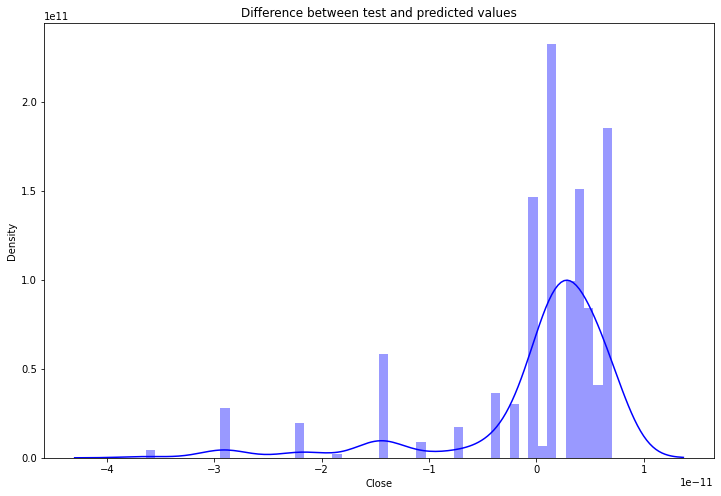

Test set evaluation:
_____________________________________
MSE: 6.032072300153857e-23
RMSE: 7.766641681031679e-12
R2 Square 1.0
SSE: 3.221126608282159e-20
Train set evaluation:
_____________________________________
MSE: 7.773583488705784e-23
RMSE: 8.816792777822207e-12
R2 Square 1.0
SSE: 9.662564276461289e-20


In [26]:
def print_evaluate(true, predicted):  
      mse = metrics.mean_squared_error(true, predicted)
      rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
      r2_square = metrics.r2_score(true, predicted)
      sse = sum((true - predicted)**2)
      print('MSE:', mse)
      print('RMSE:', rmse)
      print('R2 Square', r2_square)
      print('SSE:', sse)

df4 = df.dropna()
X = df4.drop(['Close', 'Symbol', 'Unix Timestamp', 'Date'], axis=1)
Y = df4['Close']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# training
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

print('Intercept of the line: ', lin_reg.intercept_)

# testing
pred = lin_reg.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 8))
sns.distplot((y_test - pred), bins=50, color='blue')
ax.set_title('Difference between test and predicted values')
plt.show()

test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

In [27]:
model = Prophet()
Date = df['Date']
Close = df['Close']
df_prophet = pd.DataFrame()
df_prophet['ds'] = Date
df_prophet['y'] = Close
df_prophet.head(10)

,ds,y
0,2021-08-18 04:00:00,44924.22
1,2021-08-17 04:00:00,45078.79
2,2021-08-16 04:00:00,46435.44
3,2021-08-15 04:00:00,47400.89
4,2021-08-14 04:00:00,46910.99
5,2021-08-13 04:00:00,47571.64
6,2021-08-12 04:00:00,45205.46
7,2021-08-11 04:00:00,45948.06
8,2021-08-10 04:00:00,45594.16
9,2021-08-09 04:00:00,45727.39


In [28]:
model.fit(df_prophet)
future_dates = model.make_future_dataframe(periods=365);
prediction = model.predict(future_dates)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'],
                    mode='lines',
                    name='Daily Close'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_upper'],
                    mode='lines',
                    name='Upper limit of predicted values'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_lower'],
                    mode='lines',
                    name='Lower limit of predicted values'))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
#from January 1 2021
pred1 = prediction.iloc[1911:2396]
pred2 = df.iloc[:122]
fig = go.Figure()
fig.add_trace(go.Scatter(x=pred2['Date'], y=pred2['Close'],
                    mode='lines',
                    name='Daily Close'))
fig.add_trace(go.Scatter(x=pred1['ds'], y=pred1['yhat'],
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=pred1['ds'], y=pred1['yhat_upper'],
                    mode='lines',
                    name='Upper limit of predicted values'))
fig.add_trace(go.Scatter(x=pred1['ds'], y=pred1['yhat_lower'],
                    mode='lines',
                    name='Lower limit of predicted values'))
fig.show()

## Trends based on the past data

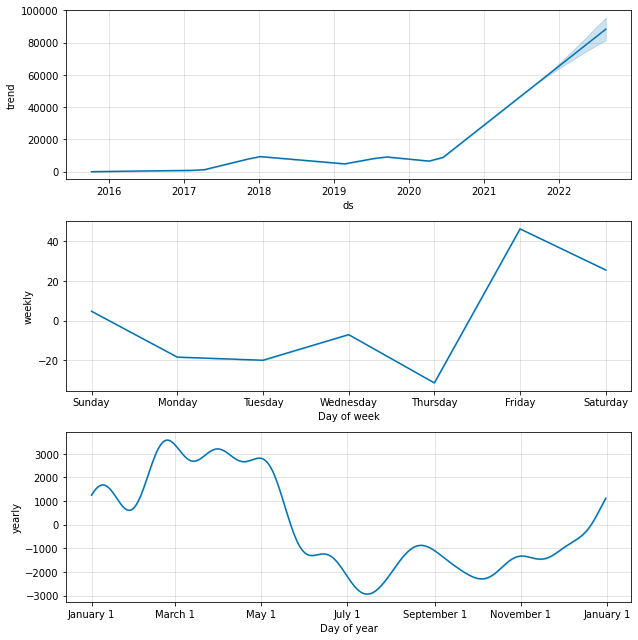

In [30]:
future= model.make_future_dataframe(periods=365)
future.tail(2)
forecast=model.predict(future)
# this shows the trends and patterns on the yearly and weekly basis
fig1 = model.plot_components(forecast)

In [31]:

today = date.today()

tickerSymbol = 'BTC-INR'
tickerData = yf.Ticker(tickerSymbol)
df = tickerData.history(period='1d', start='2010-10-08', end=today)
df.reset_index(inplace=True)

model = Prophet()
Date = df['Date']
Close = df['Close']
df_prophet = pd.DataFrame()
df_prophet['ds'] = Date
df_prophet['y'] = Close
df_prophet.head(10)

model.fit(df_prophet)
future_dates = model.make_future_dataframe(periods=365);
prediction = model.predict(future_dates)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'],
                    mode='lines',
                    name='Daily Close'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat'],
                    mode='lines',
                    name='Prediction'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_upper'],
                    mode='lines',
                    name='Upper limit of predicted values'))
fig.add_trace(go.Scatter(x=prediction['ds'], y=prediction['yhat_lower'],
                    mode='lines',
                    name='Lower limit of predicted values'))
fig.show()



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-18,5.777806e+05,2.337073e+05,9.397476e+05,5.777806e+05,5.777806e+05,5021.971422,5021.971422,5021.971422,5021.971422,5021.971422,5021.971422,0.0,0.0,0.0,5.828026e+05
1,2019-09-19,5.778977e+05,2.247194e+05,9.627764e+05,5.778977e+05,5.778977e+05,2007.679419,2007.679419,2007.679419,2007.679419,2007.679419,2007.679419,0.0,0.0,0.0,5.799054e+05
2,2019-09-20,5.780148e+05,2.006905e+05,9.480177e+05,5.780148e+05,5.780148e+05,881.656658,881.656658,881.656658,881.656658,881.656658,881.656658,0.0,0.0,0.0,5.788964e+05
3,2019-09-21,5.781318e+05,1.957629e+05,9.291326e+05,5.781318e+05,5.781318e+05,142.912540,142.912540,142.912540,142.912540,142.912540,142.912540,0.0,0.0,0.0,5.782748e+05
4,2019-09-22,5.782489e+05,2.012156e+05,9.299418e+05,5.782489e+05,5.782489e+05,-5005.860450,-5005.860450,-5005.860450,-5005.860450,-5005.860450,-5005.860450,0.0,0.0,0.0,5.732431e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058,2022-08-15,-1.674182e+06,-4.752467e+06,1.408867e+06,-4.676631e+06,1.359940e+06,-2045.146662,-2045.146662,-2045.146662,-2045.146662,-2045.146662,-2045.146662,0.0,0.0,0.0,-1.676227e+06
1059,2022-08-16,-1.685552e+06,-4.774531e+06,1.357097e+06,-4.699288e+06,1.362737e+06,-1003.212927,-1003.212927,-1003.212927,-1003.212927,-1003.212927,-1003.212927,0.0,0.0,0.0,-1.686556e+06
1060,2022-08-17,-1.696923e+06,-4.808101e+06,1.403932e+06,-4.723481e+06,1.365078e+06,5021.971422,5021.971422,5021.971422,5021.971422,5021.971422,5021.971422,0.0,0.0,0.0,-1.691901e+06
1061,2022-08-18,-1.708293e+06,-4.796915e+06,1.307469e+06,-4.747076e+06,1.368627e+06,2007.679419,2007.679419,2007.679419,2007.679419,2007.679419,2007.679419,0.0,0.0,0.0,-1.706285e+06


In [34]:
df_close = df['Close']
b = len(prediction)-365
df_pred_close = prediction['yhat'][:b]
df_pred_date = prediction['ds'][:b]
diff = np.subtract(df_pred_close, df_close)
df1 = pd.DataFrame()
df1['Date'] = df_pred_date
df1['Actual Close'] = df_close
df1['Predicted Close'] = df_pred_close
df1['Difference'] = diff
fig = px.line(df1, x="Date", y="Difference", title="Difference of Predicted Close and Actual Close");
fig.show()

In [35]:
df1

,Date,Actual Close,Predicted Close,Difference
0,2019-09-18,7.259610e+05,5.828026e+05,-1.431584e+05
1,2019-09-19,7.329512e+05,5.799054e+05,-1.530458e+05
2,2019-09-20,7.249939e+05,5.788964e+05,-1.460975e+05
3,2019-09-21,7.134639e+05,5.782748e+05,-1.351892e+05
4,2019-09-22,7.170186e+05,5.732431e+05,-1.437755e+05
...,...,...,...,...
693,2021-08-15,3.491690e+06,2.470999e+06,-1.020691e+06
694,2021-08-16,3.410852e+06,2.462589e+06,-9.482633e+05
695,2021-08-17,3.323759e+06,2.452261e+06,-8.714982e+05
696,2021-08-18,3.327387e+06,2.446915e+06,-8.804714e+05


In [36]:
pred = pd.DataFrame()
pred['Date'] = prediction['ds']
pred['Lower limit of Prediction'] = prediction['yhat_lower']
pred['Upper limit of Prediction'] = prediction['yhat_upper']
pred['Prediction'] = prediction['yhat']
print(type(pred), today)

a = pred.loc[pred['Date'] == '2021-05-11']
print(a)

<class 'pandas.core.frame.DataFrame'> 2021-08-19
          Date  ...    Prediction
597 2021-05-11  ...  3.566557e+06

[1 rows x 4 columns]


In [37]:
pred.head(10)

,Date,Lower limit of Prediction,Upper limit of Prediction,Prediction
0,2019-09-18,233707.339695,939747.582714,582802.576659
1,2019-09-19,224719.371307,962776.443143,579905.362234
2,2019-09-20,200690.543923,948017.685516,578896.417051
3,2019-09-21,195762.947119,929132.620086,578274.750511
4,2019-09-22,201215.629847,929941.764226,573243.055100
5,2019-09-23,243618.422363,949949.497473,576320.846466
6,2019-09-24,223198.882342,937389.563128,577479.857778
7,2019-09-25,225190.805040,934468.166727,583622.119705
8,2019-09-26,229908.238994,939945.396073,580724.905281
9,2019-09-27,214055.220018,977411.227352,579715.960097


In [38]:
a = pred['Prediction'].where(pred['Date'] == today)
print(a)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1058   NaN
1059   NaN
1060   NaN
1061   NaN
1062   NaN
Name: Prediction, Length: 1063, dtype: float64
